In [1]:
print('Hello world!')

Hello world!


### Experimental Setting

In [2]:
REVERSE_INPUT = True
REVERSE_OUTPUT = True
OPERATOR = '+'
NUM1_RANGE = (10,99)
NUM2_RANGE = (10,99)
TRAINING_SAMPLE_SIZE = 100
TEST_SAMPLE_SIZE = 10
TRAINING_EPOCH = 50

### Transformer for Calculation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [4]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed_all(12345)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Dataset Class
class AdditionDataset(Dataset):
    def __init__(self, num_samples):
        self.samples = [self.generate_sample() for _ in range(num_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    @staticmethod
    def generate_sample(operator=OPERATOR, reverse_in=REVERSE_INPUT, reverse_out=REVERSE_OUTPUT):
        num1 = random.randint(NUM1_RANGE[0], NUM1_RANGE[1])
        num2 = random.randint(NUM2_RANGE[0], NUM2_RANGE[1])
        result = eval(f'{num1}{operator}{num2}')

        if reverse_in:
            num1 = str(num1)[::-1]
            num2 = str(num2)[::-1]
        else:
            num1 = str(num1)
            num2 = str(num2)

        if reverse_out:
            result = str(result)[::-1]
        else:
            result = str(result)

        return num1+operator+num2+'='+result

In [7]:
# Hyperparameter
MAX_LEN = 16
EMBED_SIZE = 384 #256
NUM_HEADS = 6 #8
NUM_LAYERS = 3 #6 #3
DROPOUT = 0 #0.1
LEARNING_RATE = 1e-6 #1e-3
EPOCHS = TRAINING_EPOCH

In [8]:
# Tokenization
ONEHOT_IDX = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, OPERATOR: 10, '=': 11}
TOKENS = ''.join(ONEHOT_IDX.keys())
VOCAB_SIZE = len(TOKENS)

def char_to_idx(char):
    return ONEHOT_IDX[char]

def idx_to_char(idx):
    return TOKENS[idx]

In [9]:
# Model definition
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, num_heads, num_layers, dropout=0.1):
        super(TransformerDecoderModel, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_size)
        self.pos_enc = nn.Embedding(max_len, embed_size)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, 
            nhead=num_heads, 
            bias=False,
            activation='gelu',
            batch_first=True,)
        
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.pos = torch.arange(0, max_len, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    def forward(self, src):
        batch_size, seq_len = src.shape
        tok_emb = self.token_emb(src)  # (batch=1, seq_len, emb_dim)
        pos_emb = self.pos_enc(self.pos)[:,:seq_len,:]
        x = self.dropout(tok_emb + pos_emb)
        memory = torch.zeros_like(x)  # No encoder output
        output = self.transformer_decoder(x, memory)
        return self.fc_out(output)

In [10]:
# Visualization
def vis_pca(data, labels, title='', show=False):
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    pca = PCA(n_components=8)
    transformed_list = pca.fit_transform(data.cpu().detach().numpy())  # (label cnt, pc cnt)

    plt.figure(figsize=(14, 14))

    pc_axes = [[0,1],[2,3],[4,5],[6,7]]
    for plot_id, (pcx, pcy) in enumerate(pc_axes):
        for point_id, transformed in enumerate(transformed_list):
            plt.subplot(2, 2, plot_id+1)  # plt.subplot(row, col, i)
            plt.xlabel(f'PC{pcx+1} ({pca.explained_variance_ratio_[pcx]*100:.1f}%)')
            plt.ylabel(f'PC{pcy+1} ({pca.explained_variance_ratio_[pcy]*100:.1f}%)')
            plt.scatter(transformed[pcx], transformed[pcy], alpha=0.25)
            plt.text(transformed[pcx], transformed[pcy], f"'{labels[point_id]}'")
            
    plt.suptitle(title)

    if show:
        plt.show()
    else:
        plt.savefig(f'emb_vis/pca_{time.strftime("%Y%m%d-%H%M%S")}.png',
                    bbox_inches='tight')
        plt.close()

# vis_pca(model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device)), TOKENS, title='Test', show=True)

In [11]:
model = TransformerDecoderModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    max_len=MAX_LEN, 
    num_heads=NUM_HEADS, 
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT,
    )
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

e:\teaching_arithmetic_replication\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
train_dataset = AdditionDataset(num_samples=TRAINING_SAMPLE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=1)

In [13]:
model = model.to(device)

In [14]:
PCA_TITLE_PREFIX = "TOP-8 Embedding PCA"

In [15]:
data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:0, Loss:N/A)')

100%|██████████| 100/100 [00:01<00:00, 54.60it/s]


Epoch 1, Loss: 1.909373733997345


100%|██████████| 100/100 [00:00<00:00, 116.40it/s]


Epoch 2, Loss: 1.8618055176734924


100%|██████████| 100/100 [00:00<00:00, 101.38it/s]


Epoch 3, Loss: 1.8285589170455934


100%|██████████| 100/100 [00:00<00:00, 112.04it/s]


Epoch 4, Loss: 1.7965000748634339


100%|██████████| 100/100 [00:00<00:00, 104.09it/s]


Epoch 5, Loss: 1.7802261626720428


100%|██████████| 100/100 [00:00<00:00, 112.04it/s]


Epoch 6, Loss: 1.7653986167907716


100%|██████████| 100/100 [00:00<00:00, 111.10it/s]


Epoch 7, Loss: 1.7474633932113648


100%|██████████| 100/100 [00:00<00:00, 110.46it/s]


Epoch 8, Loss: 1.7321090400218964


100%|██████████| 100/100 [00:00<00:00, 121.14it/s]


Epoch 9, Loss: 1.723429310321808


100%|██████████| 100/100 [00:00<00:00, 110.39it/s]


Epoch 10, Loss: 1.709659411907196


100%|██████████| 100/100 [00:00<00:00, 103.94it/s]


Epoch 11, Loss: 1.703817913532257


100%|██████████| 100/100 [00:00<00:00, 118.12it/s]


Epoch 12, Loss: 1.6947401809692382


100%|██████████| 100/100 [00:00<00:00, 112.48it/s]


Epoch 13, Loss: 1.685101602077484


100%|██████████| 100/100 [00:00<00:00, 113.42it/s]


Epoch 14, Loss: 1.6771631276607513


100%|██████████| 100/100 [00:00<00:00, 101.02it/s]


Epoch 15, Loss: 1.6742226362228394


100%|██████████| 100/100 [00:00<00:00, 113.06it/s]


Epoch 16, Loss: 1.6628162801265716


100%|██████████| 100/100 [00:00<00:00, 109.86it/s]


Epoch 17, Loss: 1.659080902338028


100%|██████████| 100/100 [00:00<00:00, 106.50it/s]


Epoch 18, Loss: 1.6523110461235047


100%|██████████| 100/100 [00:00<00:00, 100.51it/s]


Epoch 19, Loss: 1.6429736948013305


100%|██████████| 100/100 [00:00<00:00, 111.28it/s]


Epoch 20, Loss: 1.6382826232910157


100%|██████████| 100/100 [00:00<00:00, 116.08it/s]


Epoch 21, Loss: 1.6301558029651642


100%|██████████| 100/100 [00:00<00:00, 109.81it/s]


Epoch 22, Loss: 1.6204243946075438


100%|██████████| 100/100 [00:00<00:00, 108.02it/s]


Epoch 23, Loss: 1.6122491264343262


100%|██████████| 100/100 [00:00<00:00, 100.99it/s]


Epoch 24, Loss: 1.605628035068512


100%|██████████| 100/100 [00:00<00:00, 105.91it/s]


Epoch 25, Loss: 1.6001717627048493


100%|██████████| 100/100 [00:00<00:00, 107.80it/s]


Epoch 26, Loss: 1.5879671037197114


100%|██████████| 100/100 [00:00<00:00, 102.80it/s]


Epoch 27, Loss: 1.578506165742874


100%|██████████| 100/100 [00:01<00:00, 93.09it/s]


Epoch 28, Loss: 1.5676890695095063


100%|██████████| 100/100 [00:01<00:00, 97.41it/s]


Epoch 29, Loss: 1.5613005030155183


100%|██████████| 100/100 [00:00<00:00, 107.93it/s]


Epoch 30, Loss: 1.5483782505989074


100%|██████████| 100/100 [00:01<00:00, 94.55it/s]


Epoch 31, Loss: 1.5421829664707183


100%|██████████| 100/100 [00:01<00:00, 95.03it/s]


Epoch 32, Loss: 1.5312910878658295


100%|██████████| 100/100 [00:01<00:00, 95.91it/s]


Epoch 33, Loss: 1.5210846734046937


100%|██████████| 100/100 [00:00<00:00, 105.64it/s]


Epoch 34, Loss: 1.508996970653534


100%|██████████| 100/100 [00:00<00:00, 106.64it/s]


Epoch 35, Loss: 1.494481770992279


100%|██████████| 100/100 [00:01<00:00, 94.80it/s]


Epoch 36, Loss: 1.4872120761871337


100%|██████████| 100/100 [00:00<00:00, 101.91it/s]


Epoch 37, Loss: 1.4740814805030822


100%|██████████| 100/100 [00:01<00:00, 96.24it/s]


Epoch 38, Loss: 1.465728600025177


100%|██████████| 100/100 [00:01<00:00, 99.71it/s]


Epoch 39, Loss: 1.4543693840503693


100%|██████████| 100/100 [00:00<00:00, 106.43it/s]


Epoch 40, Loss: 1.4397561502456666


100%|██████████| 100/100 [00:00<00:00, 107.28it/s]


Epoch 41, Loss: 1.4330081236362457


100%|██████████| 100/100 [00:00<00:00, 107.43it/s]


Epoch 42, Loss: 1.4211716043949127


100%|██████████| 100/100 [00:00<00:00, 107.46it/s]


Epoch 43, Loss: 1.411518405675888


100%|██████████| 100/100 [00:01<00:00, 96.15it/s]


Epoch 44, Loss: 1.3960870051383971


100%|██████████| 100/100 [00:00<00:00, 112.21it/s]


Epoch 45, Loss: 1.3919534945487977


100%|██████████| 100/100 [00:00<00:00, 100.36it/s]


Epoch 46, Loss: 1.379759089946747


100%|██████████| 100/100 [00:00<00:00, 104.98it/s]


Epoch 47, Loss: 1.3724954748153686


100%|██████████| 100/100 [00:00<00:00, 128.78it/s]


Epoch 48, Loss: 1.362641041278839


100%|██████████| 100/100 [00:00<00:00, 118.47it/s]


Epoch 49, Loss: 1.3573599922657014


100%|██████████| 100/100 [00:00<00:00, 128.64it/s]


Epoch 50, Loss: 1.3446239233016968


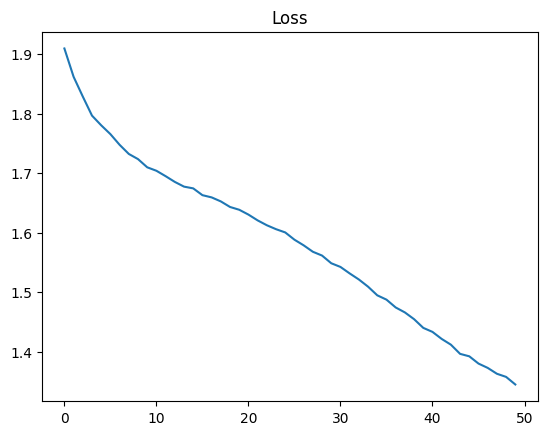

In [16]:
# Train
model.train()
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in tqdm(train_loader):
        for data in batch:
            input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
            target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)

            optimizer.zero_grad()
            output = model(input_tensor)  # (batch=1, seq_len) -> (batch=1, seq_len, VOCAB_SIZE)

            output_onehot = np.argmax(output.cpu().detach(), axis=2)  # (batch=1, seq_len)
            
            pred = output.view(-1, VOCAB_SIZE)  # (seq_len, VOCAB_SIZE)
            true = target_tensor.view(-1)  # (seq_len)
            # loss = F.cross_entropy(pred, true)  # Compare all (inefficient)
            
            eqi = data[:-1].index('=')
            lhs = torch.zeros_like(pred[:eqi])
            for i in range(eqi):
                lhs[i][true[i]] = 1
            rhs_pred = torch.cat((lhs, pred[eqi:]), dim=0)  # (seq_len, VOCAB_SIZE)
            loss = F.cross_entropy(rhs_pred, true)  # Compare RHS
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()/len(batch)
    losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]}")
    
    data = model.token_emb(torch.tensor([char_to_idx(token) for token in TOKENS]).to(device))
    vis_pca(data, TOKENS, title=f'{PCA_TITLE_PREFIX} (Epoch:{epoch+1}, Loss:{losses[-1]:.2f})')

plt.title('Loss'); plt.plot(losses)

In [17]:
test_dataset = AdditionDataset(num_samples=TEST_SAMPLE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

def evaluate_model(model, data):
    model.eval()  # 모델을 평가 모드로 설정
    
    pred_total = pred_correct = 0
    with torch.no_grad():
        for batch in test_loader:
            for data in batch:
                input_tensor = torch.tensor([char_to_idx(char) for char in data[:-1]], dtype=torch.long).unsqueeze(0).to(device)
                target_tensor = torch.tensor([char_to_idx(char) for char in data[1:]], dtype=torch.long).unsqueeze(0).to(device)
    
                output = model(input_tensor)

                output_onehot = np.argmax(output.cpu().detach(), axis=2)
                eqi = data[:-1].index('=')
                pred_total += len(target_tensor[0][eqi:])
                pred_correct += sum(1 for i, j in zip(target_tensor[0][eqi:], output_onehot[0][eqi:]) if i == j)
                print('sentence: ', data)
                print('target_char: ', [idx_to_char(i) for i in target_tensor[0][eqi:]])
                print('output_char: ', [idx_to_char(i) for i in output_onehot[0][eqi:]])

    return {'accuracy': pred_correct/pred_total}

accuracy = evaluate_model(model, test_dataset)['accuracy']

sentence:  94+76=611
target_char:  ['6', '1', '1']
output_char:  ['6', '1', '1']
sentence:  88+34=131
target_char:  ['1', '3', '1']
output_char:  ['1', '4', '1']
sentence:  94+37=221
target_char:  ['2', '2', '1']
output_char:  ['2', '2', '1']
sentence:  17+61=78
target_char:  ['7', '8']
output_char:  ['7', '7']
sentence:  34+76=011
target_char:  ['0', '1', '1']
output_char:  ['0', '1', '1']
sentence:  31+83=15
target_char:  ['1', '5']
output_char:  ['1', '9']
sentence:  45+72=18
target_char:  ['1', '8']
output_char:  ['1', '9']
sentence:  01+69=601
target_char:  ['6', '0', '1']
output_char:  ['6', '0', '1']
sentence:  09+02=011
target_char:  ['0', '1', '1']
output_char:  ['0', '0', '1']
sentence:  31+42=73
target_char:  ['7', '3']
output_char:  ['7', '4']


In [18]:
print("Accuracy: ", accuracy)

Accuracy:  0.7692307692307693


In [19]:
# Write experimental results
filename=f'exp_res/{accuracy*100:.0f}-InRev{REVERSE_INPUT}-OutRev{REVERSE_OUTPUT}-{NUM1_RANGE}-{NUM2_RANGE}-Train{TRAINING_SAMPLE_SIZE}-Test{TEST_SAMPLE_SIZE}-Epoch{TRAINING_EPOCH}-{time.strftime("%Y%m%d-%H%M%S")}.txt'
with open(filename, 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Loss: {losses}\n')

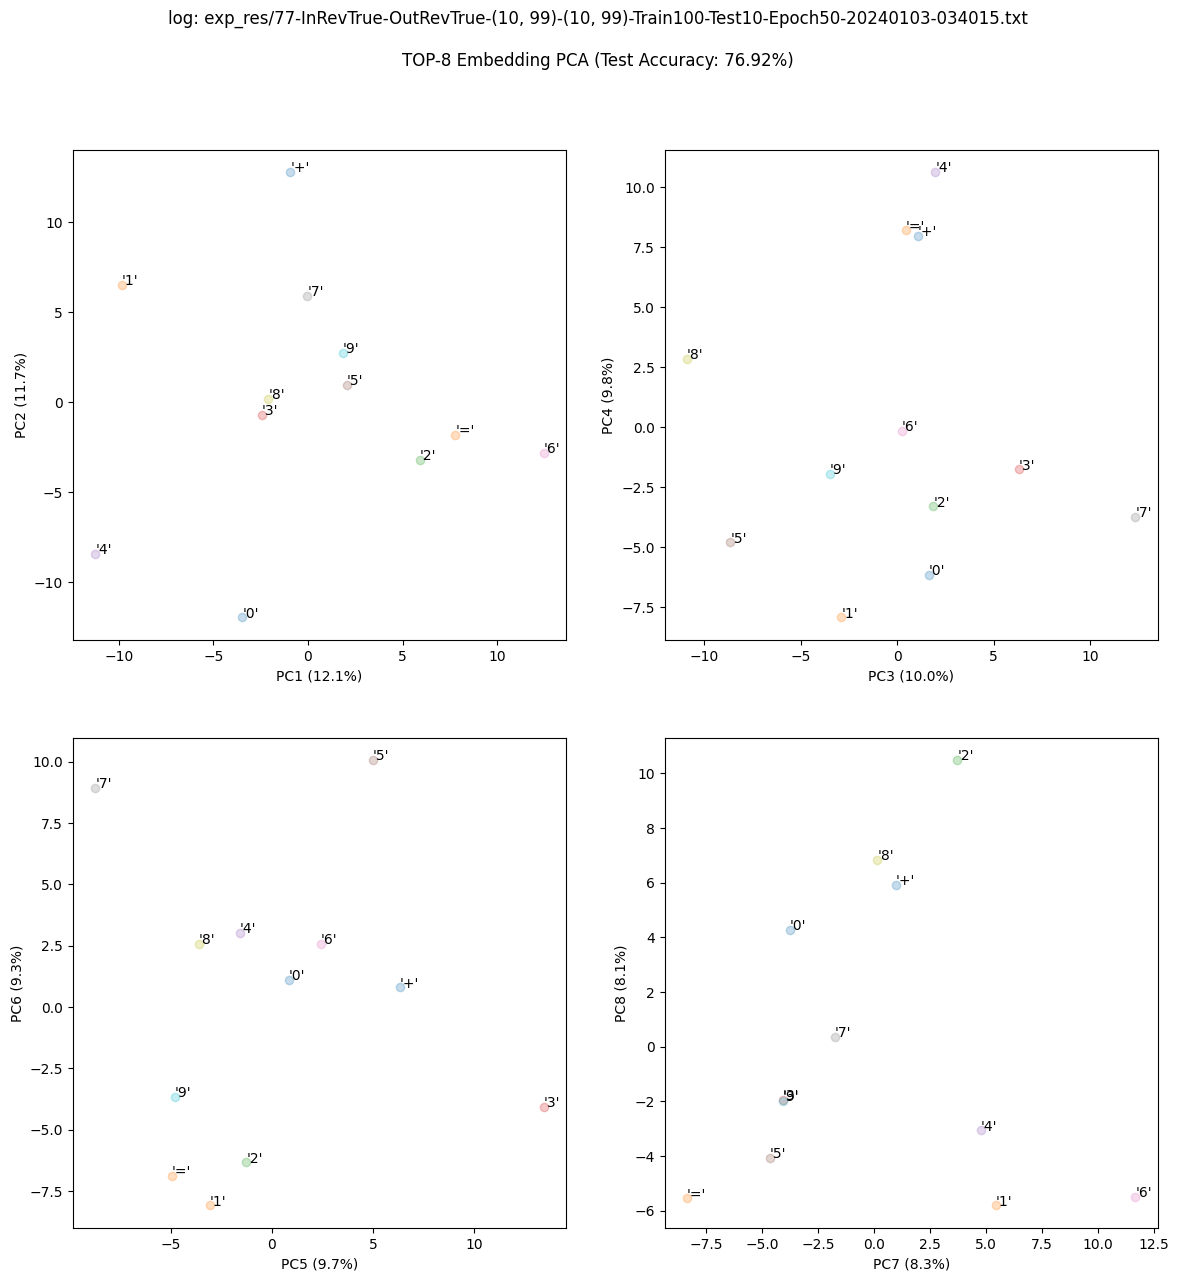

In [20]:
vis_pca(data, TOKENS, title=f'log: {filename}\n\n{PCA_TITLE_PREFIX} (Test Accuracy: {accuracy*100:.2f}%)', show=True)